In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from a .env file located in the same directory as this script
load_dotenv()

# Now you can access the environment variable
cloud_project = os.environ.get("GOOGLE_CLOUD_PROJECT_NAME")
key_path = os.environ.get("GOOGLE_CLOUD_KEY_PATH")

print(cloud_project)
print(key_path)

hotspotstoplight
C:\Users\Nissim\Documents\google-keys\hotspotstoplight-67f59ac93e89.json


In [2]:
import ee
ee.Authenticate()

True

In [3]:
ee.Initialize(project=cloud_project)


In [4]:
import restee as ree

# get an authenticated cloud session for requesting data
session = ree.EESession(cloud_project, key_path)

In [5]:
# use ee to get a featurecollection for USA
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
camerica= countries.filter(ee.Filter.eq("wld_rgn", "Central America"))

In [6]:
# define the domain imagery will be requested for at ~1km resolution
# in this case it is the computed Central America FeatureCollection
domain = ree.Domain.from_ee_geometry(session,camerica,resolution=0.01)

In [7]:
# define some image computations
# here we calculate median NDVI for the summer months
modis = (
    ee.ImageCollection("MODIS/006/MOD09GA")
    .filterDate("2020-06-01","2020-09-01")
    .map(lambda x: x.normalizedDifference(["sur_refl_b02","sur_refl_b01"]))
    .median()
    .rename("NDVI")
)

In [8]:
# request the ee.Image pixels as a xarray dataset for the domain
ndvi_ds = ree.img_to_xarray(session,domain,modis,no_data_value=0)

In [10]:
ndvi_ds

<xarray.Dataset>
Dimensions:  (lat: 1130, lon: 1509)
Coordinates:
  * lon      (lon) float64 -92.23 -92.22 -92.21 -92.2 ... -77.17 -77.16 -77.15
  * lat      (lat) float64 18.49 18.48 18.47 18.46 ... 7.235 7.225 7.215 7.205
Data variables:
    NDVI     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

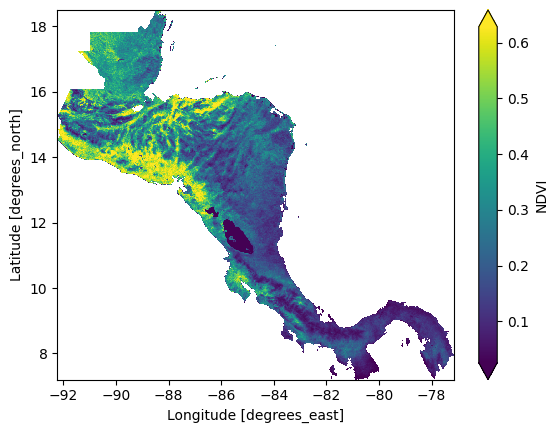

In [11]:
ndvi_ds.NDVI.plot(robust=True,cmap="viridis")

In [10]:
# List of your GCS image paths
gcs_paths = "gs://hotspotstoplight_floodmapping/data/costa_rica/inputs/input_data_2018-10-02.tif"

In [11]:
import geemap

In [12]:
image = geemap.load_GeoTIFF(gcs_paths)

In [118]:
cr= countries.filter(ee.Filter.eq("country_na", "Costa Rica"))
cr_domain = ree.Domain.from_ee_geometry(session,cr,resolution=0.005)

In [119]:
# request the ee.Image pixels as a xarray dataset for the domain
image_xr = ree.img_to_xarray(session, cr_domain, image, no_data_value=0)

In [93]:
image_xr

<xarray.Dataset>
Dimensions:                (lat: 639, lon: 682)
Coordinates:
  * lon                    (lon) float64 -85.95 -85.95 -85.94 ... -82.55 -82.55
  * lat                    (lat) float64 11.22 11.22 11.21 ... 8.043 8.038 8.033
Data variables: (12/16)
    elevation              (lat, lon) float32 nan nan nan nan ... nan nan nan
    landcover              (lat, lon) float32 nan nan nan nan ... nan nan nan
    slope                  (lat, lon) float32 nan nan nan nan ... nan nan nan
    built_characteristics  (lat, lon) float32 nan nan nan nan ... nan nan nan
    flow_direction         (lat, lon) float32 nan nan nan nan ... nan nan nan
    stream_distance        (lat, lon) float32 nan nan nan nan ... nan nan nan
    ...                     ...
    cti                    (lat, lon) float32 nan nan nan nan ... nan nan nan
    tpi                    (lat, lon) float32 nan nan nan nan ... nan nan nan
    tri                    (lat, lon) float32 nan nan nan nan ... nan nan nan
    pcurv                  (lat, lon) float32 nan nan nan nan ... nan nan nan
    tcurv                  (lat, lon) float32 nan nan nan nan ... nan nan nan
    aspect                 (lat, lon) float32 nan nan nan nan ... nan nan nan

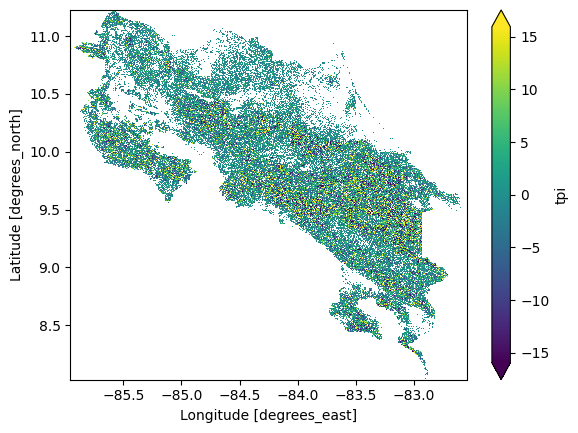

In [130]:
image_xr.tpi.plot(robust=True,cmap="viridis")

In [95]:
# return the bands and their indexes
image_np

<bound method Mapping.values of <xarray.Dataset>
Dimensions:                (lat: 322, lon: 343)
Coordinates:
  * lon                    (lon) float64 -85.97 -85.95 -85.94 ... -82.55 -82.54
  * lat                    (lat) float64 11.23 11.22 11.21 ... 8.045 8.035 8.025
Data variables: (12/16)
    elevation              (lat, lon) float32 nan nan nan nan ... nan nan nan
    landcover              (lat, lon) float32 nan nan nan nan ... nan nan nan
    slope                  (lat, lon) float32 nan nan nan nan ... nan nan nan
    built_characteristics  (lat, lon) float32 nan nan nan nan ... nan nan nan
    flow_direction         (lat, lon) float32 nan nan nan nan ... nan nan nan
    stream_distance        (lat, lon) float32 nan nan nan nan ... nan nan nan
    ...                     ...
    cti                    (lat, lon) float32 nan nan nan nan ... nan nan nan
    tpi                    (lat, lon) float32 nan nan nan nan ... nan nan nan
    tri                    (lat, lon) float32 nan

In [96]:
# covnert the xarray dataset to a numpy array
image_np = image_xr.values

In [113]:
import numpy as np
import xarray as xr
from sklearn.preprocessing import OneHotEncoder

# Assuming image_xr is your xarray dataset

# Drop coordinates
# image_xr = image_xr.drop_vars(['lon', 'lat'])

# One-hot encode the landcover band
landcover_data = np.array(image_xr['landcover'])
encoder = OneHotEncoder(sparse_output=False)
landcover_encoded = encoder.fit_transform(landcover_data.reshape(-1, 1))

# Assuming the original dimensions (height and width) are accessible
height, width = landcover_data.shape

# Reshape landcover_encoded to a 3D array: height x width x number of encoded classes
landcover_encoded_reshaped = landcover_encoded.reshape(height, width, -1)

# Pull the flooded_mask band into a separate np array
flooded_mask = np.array(image_xr['flooded_mask'])

# Convert other bands to numpy arrays
other_bands = [band for band in image_xr.data_vars if band not in ['landcover', 'flooded_mask']]
other_data = np.stack([np.array(image_xr[band]) for band in other_bands], axis=-1)
# Concatenate landcover_encoded_reshaped with other_data along the third dimension (bands)
other_data= np.concatenate([other_data, landcover_encoded_reshaped], axis=-1)

# Now, other_data contains your non-coordinates, non-landcover, and non-flooded_mask bands
# landcover_encoded contains the one-hot encoded landcover data
# flooded_mask contains the flooded mask data

In [114]:
other_data.shape

(639, 682, 24)

In [115]:
other_data

array([[[nan, nan, nan, ...,  0.,  0.,  1.],
        [nan, nan, nan, ...,  0.,  0.,  1.],
        [nan, nan, nan, ...,  0.,  0.,  1.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  1.],
        [nan, nan, nan, ...,  0.,  0.,  1.],
        [nan, nan, nan, ...,  0.,  0.,  1.]],

       [[nan, nan, nan, ...,  0.,  0.,  1.],
        [nan, nan, nan, ...,  0.,  0.,  1.],
        [nan, nan, nan, ...,  0.,  0.,  1.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  1.],
        [nan, nan, nan, ...,  0.,  0.,  1.],
        [nan, nan, nan, ...,  0.,  0.,  1.]],

       [[nan, nan, nan, ...,  0.,  0.,  1.],
        [nan, nan, nan, ...,  0.,  0.,  1.],
        [nan, nan, nan, ...,  0.,  0.,  1.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  1.],
        [nan, nan, nan, ...,  0.,  0.,  1.],
        [nan, nan, nan, ...,  0.,  0.,  1.]],

       ...,

       [[nan, nan, nan, ...,  0.,  0.,  1.],
        [nan, nan, nan, ...,  0.,  0.,  1.],
        [nan, nan, nan, ...,  0.,  0.,  1.

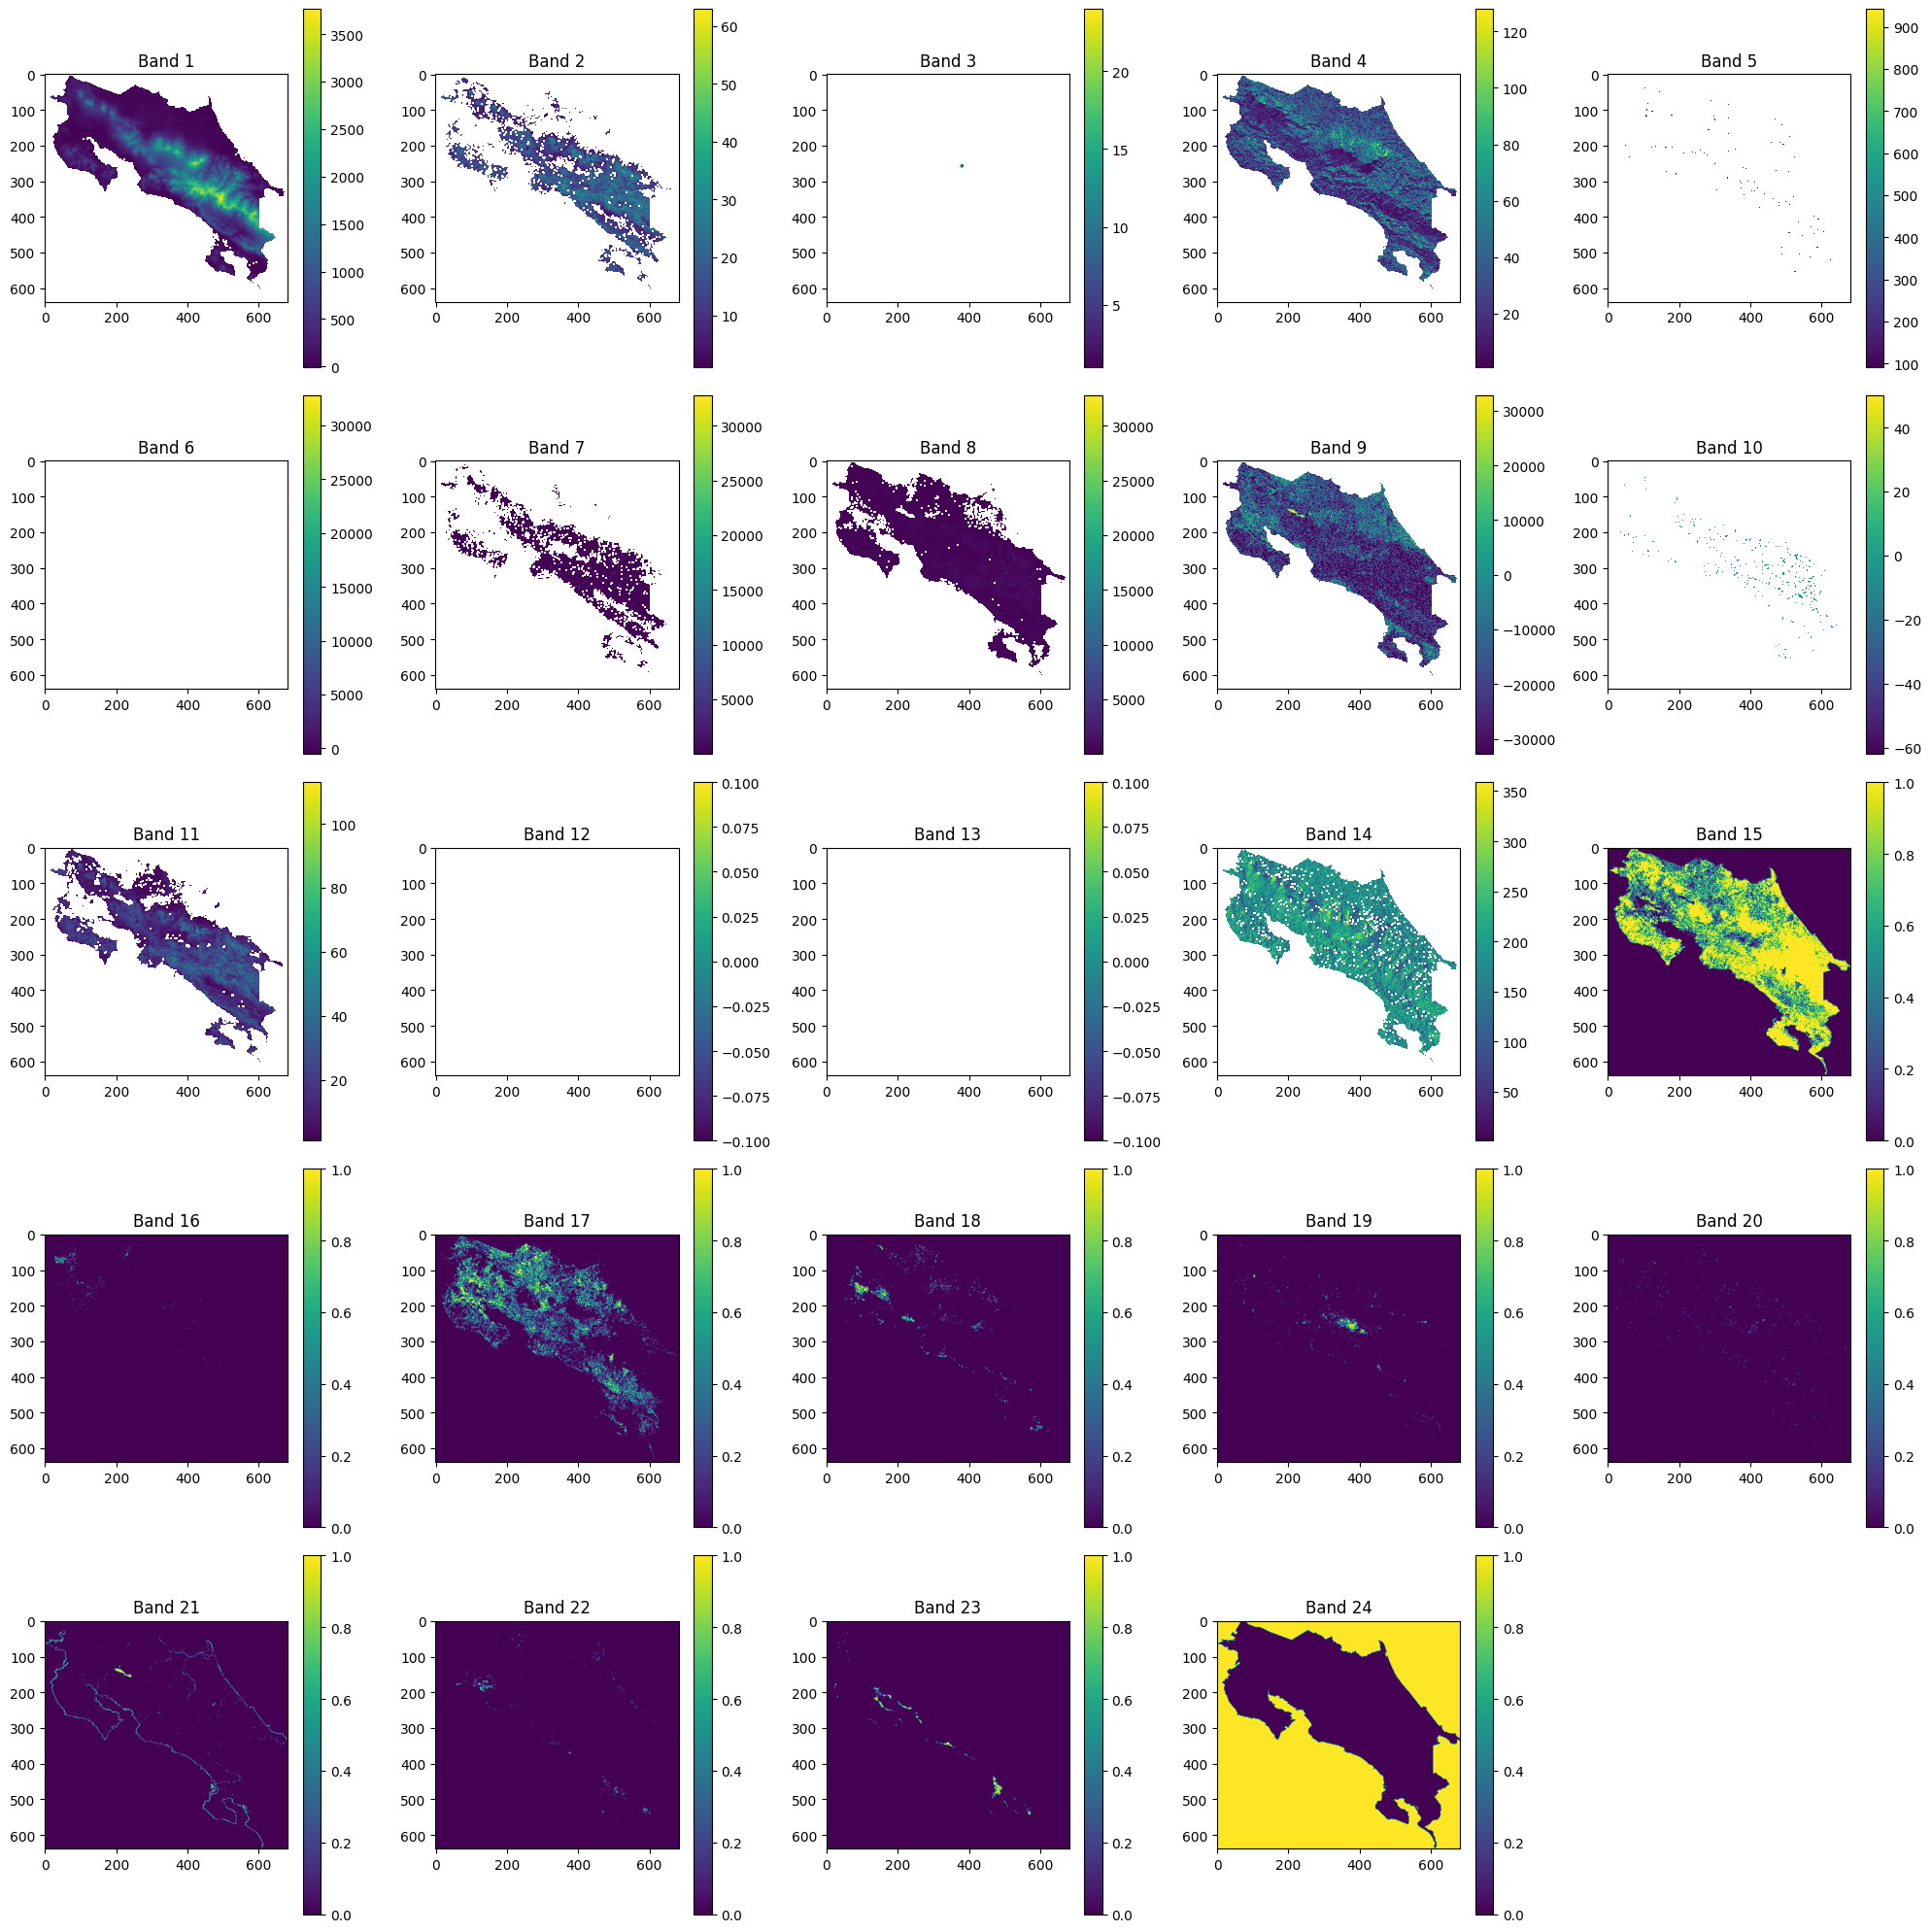

In [116]:
# plot the first band in other_data using matplotlib
import matplotlib.pyplot as plt

# Assuming other_data is your 3D array with shape (height, width, bands)
bands = other_data.shape[2]

# Calculate grid size for plots
n_cols = int(np.ceil(np.sqrt(bands)))  # Number of columns
n_rows = int(np.ceil(bands / n_cols))  # Number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

for i in range(bands):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(other_data[:, :, i], cmap='viridis')
    ax.set_title(f'Band {i+1}')
    fig.colorbar(im, ax=ax)

# If the number of subplots is not a perfect square, some subplots might be empty and can be turned off.
for i in range(bands, n_rows * n_cols):
    axes.flat[i].axis('off')

plt.tight_layout()
plt.show()

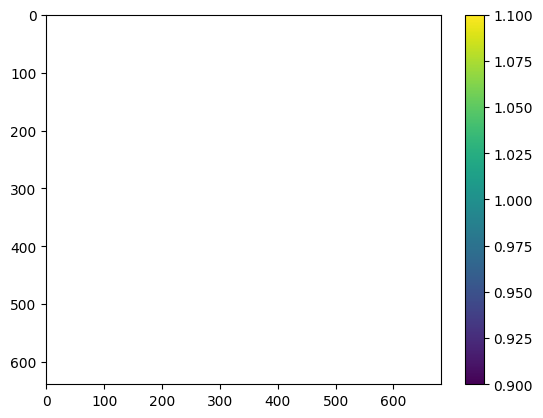

In [131]:
# plot the flooded_mask using matplotlib
plt.imshow(flooded_mask, cmap='viridis')
plt.colorbar()
plt.show()

In [45]:
import numpy as np

In [146]:
import torch
import matplotlib.pyplot as plt
import pystac
import torch
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import download_url



TypeError: unhashable type: 'list'

In [147]:
torch.manual_seed(1)

In [149]:
from torchgeo.samplers import RandomGeoSampler

sampler = RandomGeoSampler(other_data, size=4096, length=3)

TypeError: unhashable type: 'list'